### Explanatiory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns

In [2]:
data_path = Path("../data/raw/1/earthquake_data_tsunami.csv")

data_df = pd.read_csv(data_path)

In [3]:
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [4]:
print("Dataset Shape:", data_df.shape)
print("\nColumn Names:", data_df.columns.tolist())
print("\nMissing Values:\n", data_df.isnull().sum())
print("\nFirst 5 rows:\n", data_df.head())
print("\nStatistical Summary:\n", data_df.describe())

Dataset Shape: (782, 13)

Column Names: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']

Missing Values:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

First 5 rows:
    magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11      

* magnitude - Earthquake strength (log scale)
* cdi - Crowd-sourced felt intensity  
* mmi - Damage-based intensity
* sig - USGS significance score - Combines magnitude + felt + impact
* nst - Station count for magnitude
* dmin - Distance to nearest station
* gap - Station coverage gap - Poor geometry = oceanic locations
* depth - Hypocenter depth - Shallow + oceanic = tsunami risk
* latitude - North-south position - Regional patterns (subduction zones)
* longitude - East-west position - Regional patterns (Pacific Rim)
* Year - Calendar year
* Month - Calendar month
* tsunami - Target (0/1)

In [5]:
counts = data_df['tsunami'].value_counts()
counts

tsunami
0    478
1    304
Name: count, dtype: int64

In [6]:
perc = data_df['tsunami'].value_counts(normalize=True).mul(100).round(2)
perc

tsunami
0    61.13
1    38.87
Name: proportion, dtype: float64

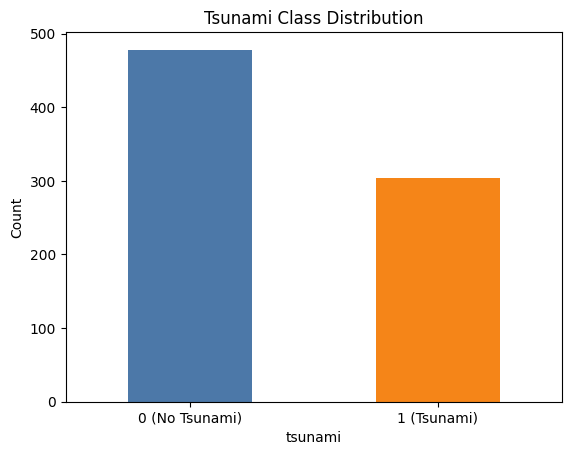

In [7]:
ax = data_df['tsunami'].value_counts().sort_index().plot(kind='bar', color=['#4c78a8', '#f58518'])
ax.set_xticklabels(['0 (No Tsunami)', '1 (Tsunami)'], rotation=0)
plt.title('Tsunami Class Distribution')
plt.ylabel('Count')
plt.xlabel('tsunami')
plt.show()

We will look at which features differ between classes. This helps prioritize features for deeper investigation.

In [8]:
num_cols = [c for c in data_df.columns if c != 'tsunami']

group_means = data_df.groupby('tsunami')[num_cols].mean().T
group_stds  = data_df.groupby('tsunami')[num_cols].std().T
delta = group_means[1] - group_means[0]
summary = pd.concat([group_means[0].rename('mean_0'),
                     group_means[1].rename('mean_1'),
                     delta.rename('mean_diff')], axis=1).round(3)

summary.reindex(summary['mean_diff'].abs().sort_values(ascending=False).index)

,mean_0,mean_1,mean_diff
nst,349.933,42.066,-307.867
longitude,65.461,32.401,-33.060
depth,69.667,85.657,15.989
sig,874.092,863.845,-10.247
Year,2009.134,2017.227,8.093
latitude,6.002,-0.335,-6.337
gap,22.792,28.571,5.779
dmin,0.617,2.440,1.823
cdi,3.929,4.970,1.042
mmi,6.136,5.694,-0.442


nst feature shows a significant difference between tsunami and non-tsunami events.

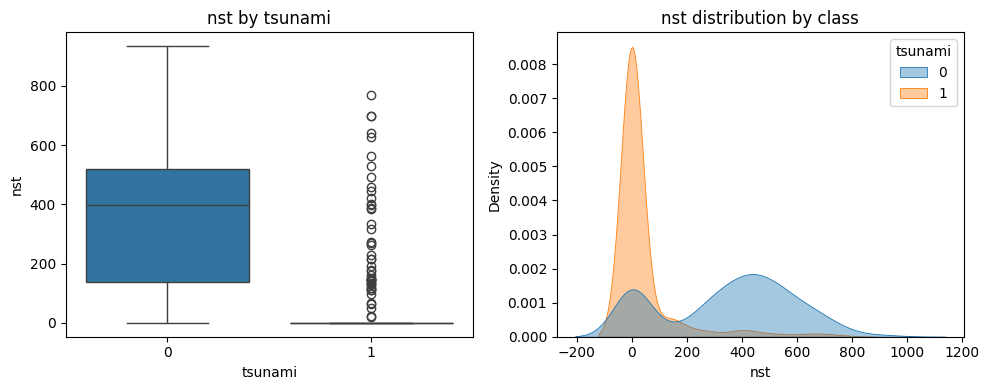

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=data_df, x='tsunami', y='nst', ax=ax[0])
ax[0].set_title('nst by tsunami'); ax[0].set_xlabel('tsunami'); ax[0].set_ylabel('nst')

sns.kdeplot(data=data_df, x='nst', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, ax=ax[1])
ax[1].set_title('nst distribution by class'); ax[1].set_xlabel('nst')

plt.tight_layout()
plt.show()

we will visualize longitude distribution across tsunami classes because it has notable mean difference

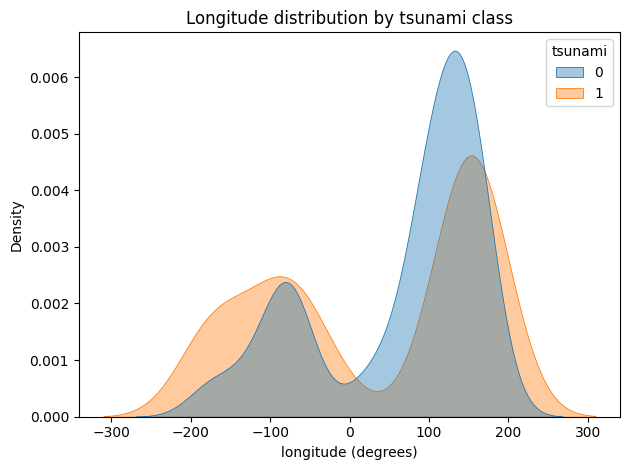

In [10]:
sns.kdeplot(data=data_df, x='longitude', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6)
plt.title('Longitude distribution by tsunami class')
plt.xlabel('longitude (degrees)')
plt.tight_layout()
plt.show()

While there's a notable mean difference longitude alone provides limited visual separation between classes. Now it is time to visualize depth distribution

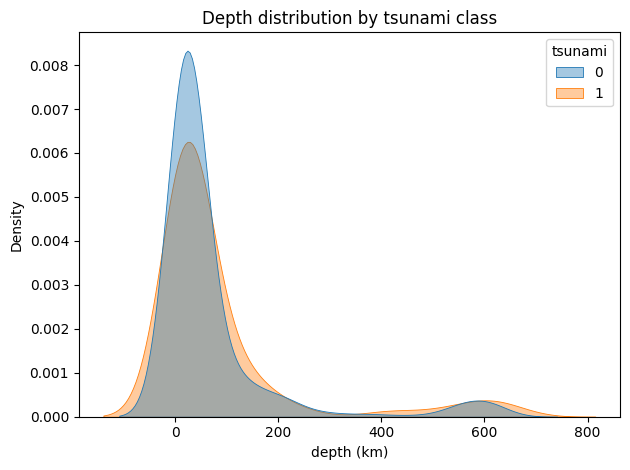

In [11]:
sns.kdeplot(data=data_df, x='depth', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6)
plt.title('Depth distribution by tsunami class')
plt.xlabel('depth (km)')
plt.tight_layout()
plt.show()

While there is a notable mean difference the distributions largely overlap

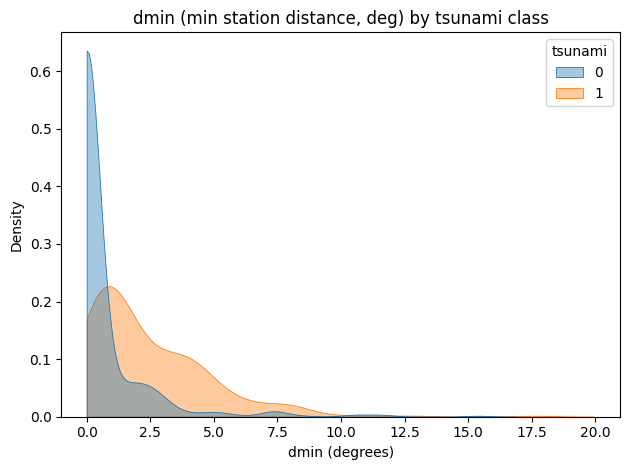

In [12]:
sns.kdeplot(data=data_df, x='dmin', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, clip=(0, None))
plt.title('dmin (min station distance, deg) by tsunami class')
plt.xlabel('dmin (degrees)')
plt.tight_layout()
plt.show()

We looked at top 3 by absolute difference and found only nst has strong separation. We will continue with Correlation Heatmap

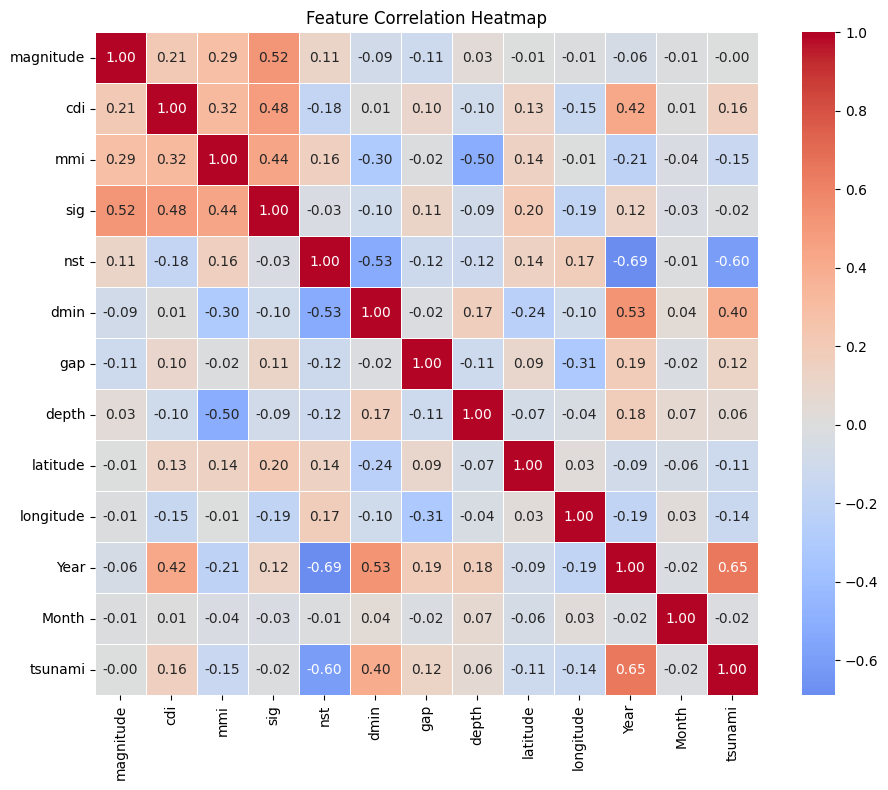

In [13]:
corr = data_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [14]:
corr['tsunami'].drop('tsunami').abs().sort_values(ascending=False).round(3)

Year         0.647
nst          0.600
dmin         0.401
cdi          0.160
mmi          0.147
longitude    0.137
gap          0.116
latitude     0.113
depth        0.057
Month        0.022
sig          0.015
magnitude    0.005
Name: tsunami, dtype: float64

Magnitude has almost zero correlation (0.005) with tsunami, this is surprising because we would expect larger earthquakes to be more likely to generate tsunamis. We will come back to that later

It is interesting. Tsunami is mostly correlated to year. It seems to be data collection artifact and should be excluded from modeling. Let's confirm this

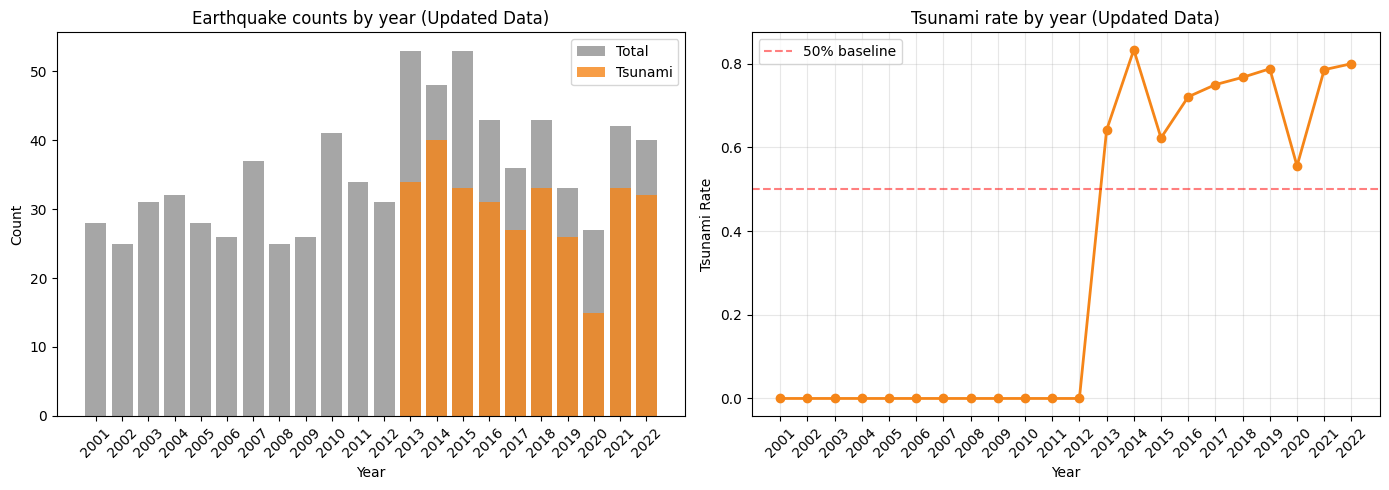


Year-Tsunami correlation: 0.647

Total years in dataset: 22

Tsunami rate by year:
    Year  tsunami_rate  total_count
0   2001         0.000           28
1   2002         0.000           25
2   2003         0.000           31
3   2004         0.000           32
4   2005         0.000           28
5   2006         0.000           26
6   2007         0.000           37
7   2008         0.000           25
8   2009         0.000           26
9   2010         0.000           41
10  2011         0.000           34
11  2012         0.000           31
12  2013         0.642           53
13  2014         0.833           48
14  2015         0.623           53
15  2016         0.721           43
16  2017         0.750           36
17  2018         0.767           43
18  2019         0.788           33
19  2020         0.556           27
20  2021         0.786           42
21  2022         0.800           40


In [15]:
year_stats = data_df.groupby('Year').agg({
    'tsunami': ['sum', 'count', 'mean']
}).reset_index()
year_stats.columns = ['Year', 'tsunami_count', 'total_count', 'tsunami_rate']

# Ensure Year is integer
year_stats['Year'] = year_stats['Year'].astype(int)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with explicit x-axis settings
ax[0].bar(year_stats['Year'], year_stats['total_count'], alpha=0.7, color='gray', label='Total')
ax[0].bar(year_stats['Year'], year_stats['tsunami_count'], alpha=0.8, color='#f58518', label='Tsunami')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Earthquake counts by year (Updated Data)')
ax[0].legend()
# Set x-axis to show all years as integers
ax[0].set_xticks(year_stats['Year'])
ax[0].set_xticklabels(year_stats['Year'], rotation=45)

# Line plot with explicit x-axis settings
ax[1].plot(year_stats['Year'], year_stats['tsunami_rate'], marker='o', color='#f58518', linewidth=2, markersize=6)
ax[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% baseline')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Tsunami Rate')
ax[1].set_title('Tsunami rate by year (Updated Data)')
# Set x-axis to show all years as integers
ax[1].set_xticks(year_stats['Year'])
ax[1].set_xticklabels(year_stats['Year'], rotation=45)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Print correlation
corr_year = data_df['Year'].corr(data_df['tsunami'])
print(f"\nYear-Tsunami correlation: {corr_year:.3f}")
print(f"\nTotal years in dataset: {len(year_stats)}")
print("\nTsunami rate by year:")
print(year_stats[['Year', 'tsunami_rate', 'total_count']].round(3))

This is clearly a dataset construction artifact now we use find another dataset for the right values and merge it with ours. The dataset we will use is : https://www.kaggle.com/datasets/andrewmvd/tsunami-dataset/data. We will continue with data_merge.ipynb

In [16]:
data_path = Path("../data/processed/earthquake_data_tsunami_updated.csv")
data_df = pd.read_csv(data_path)

In [17]:
print("Updated Dataset Overview:")
print(f"Shape: {data_df.shape}")
print(f"\nColumns: {data_df.columns.tolist()}")
print(f"\nMissing values:\n{data_df.isnull().sum()}")
print(f"\nClass balance:")
print(data_df['tsunami'].value_counts())
print(f"\nYear range: {data_df['Year'].min()} - {data_df['Year'].max()}")

data_df.head()

Updated Dataset Overview:
Shape: (700, 13)

Columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']

Missing values:
magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

Class balance:
tsunami
0    374
1    326
Name: count, dtype: int64

Year range: 2001 - 2020


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,6.7,5,5,776,0,1.319,19.0,10.00,-39.3264,-74.9067,2020,12,1
1,7.0,8,7,1527,0,1.518,18.0,21.00,37.8973,26.7953,2020,10,0
2,7.6,9,7,1165,0,0.230,36.0,28.37,54.6620,-159.6750,2020,10,1
3,6.9,0,3,732,0,11.255,16.0,10.00,0.9604,-26.8332,2020,9,1
4,6.5,6,6,674,0,0.388,49.0,16.00,-27.9285,-71.3937,2020,9,0


In [18]:
pd.DataFrame(data_df.groupby("Year"))

,0,1
0,2001,magnitude cdi mmi sig nst dmin ga...
1,2002,magnitude cdi mmi sig nst dmin gap...
2,2003,magnitude cdi mmi sig nst dmin ...
3,2004,magnitude cdi mmi sig nst dmin ga...
4,2005,magnitude cdi mmi sig nst dmin ga...
5,2006,magnitude cdi mmi sig nst dmin g...
6,2007,magnitude cdi mmi sig nst dmin ga...
7,2008,magnitude cdi mmi sig nst dmin ga...
8,2009,magnitude cdi mmi sig nst dmin ga...
9,2010,magnitude cdi mmi sig nst dmin ...


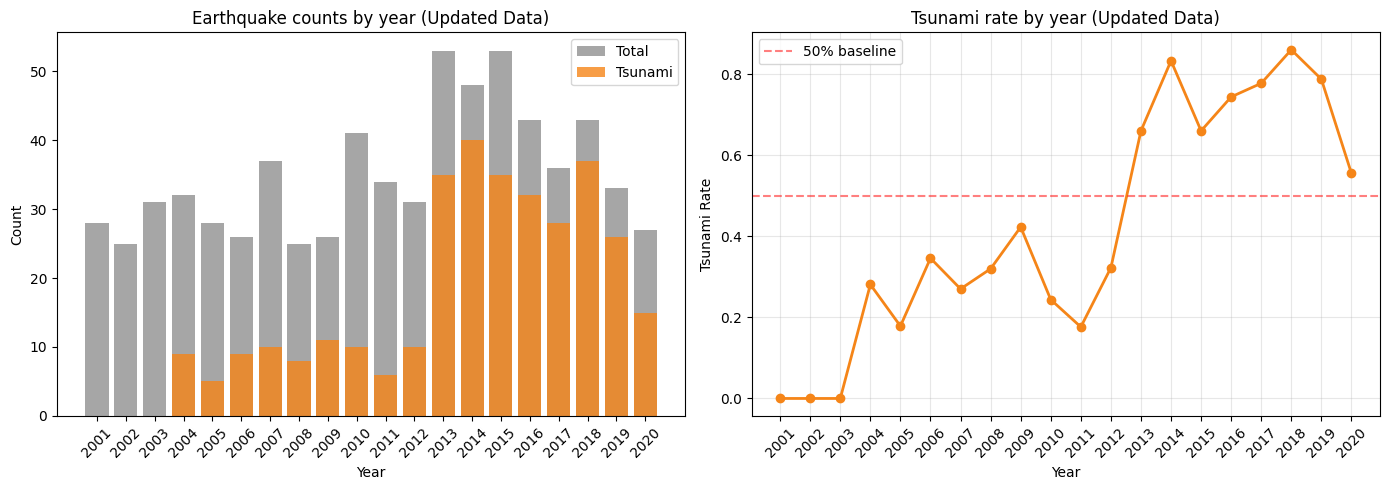


Year-Tsunami correlation: 0.504

Total years in dataset: 20

Tsunami rate by year:
    Year  tsunami_rate  total_count
0   2001         0.000           28
1   2002         0.000           25
2   2003         0.000           31
3   2004         0.281           32
4   2005         0.179           28
5   2006         0.346           26
6   2007         0.270           37
7   2008         0.320           25
8   2009         0.423           26
9   2010         0.244           41
10  2011         0.176           34
11  2012         0.323           31
12  2013         0.660           53
13  2014         0.833           48
14  2015         0.660           53
15  2016         0.744           43
16  2017         0.778           36
17  2018         0.860           43
18  2019         0.788           33
19  2020         0.556           27


In [19]:
year_stats = data_df.groupby('Year').agg({
    'tsunami': ['sum', 'count', 'mean']
}).reset_index()
year_stats.columns = ['Year', 'tsunami_count', 'total_count', 'tsunami_rate']

# Ensure Year is integer
year_stats['Year'] = year_stats['Year'].astype(int)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with explicit x-axis settings
ax[0].bar(year_stats['Year'], year_stats['total_count'], alpha=0.7, color='gray', label='Total')
ax[0].bar(year_stats['Year'], year_stats['tsunami_count'], alpha=0.8, color='#f58518', label='Tsunami')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Earthquake counts by year (Updated Data)')
ax[0].legend()
# Set x-axis to show all years as integers
ax[0].set_xticks(year_stats['Year'])
ax[0].set_xticklabels(year_stats['Year'], rotation=45)

# Line plot with explicit x-axis settings
ax[1].plot(year_stats['Year'], year_stats['tsunami_rate'], marker='o', color='#f58518', linewidth=2, markersize=6)
ax[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% baseline')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Tsunami Rate')
ax[1].set_title('Tsunami rate by year (Updated Data)')
# Set x-axis to show all years as integers
ax[1].set_xticks(year_stats['Year'])
ax[1].set_xticklabels(year_stats['Year'], rotation=45)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Print correlation
corr_year = data_df['Year'].corr(data_df['tsunami'])
print(f"\nYear-Tsunami correlation: {corr_year:.3f}")
print(f"\nTotal years in dataset: {len(year_stats)}")
print("\nTsunami rate by year:")
print(year_stats[['Year', 'tsunami_rate', 'total_count']].round(3))

There is still an imbalance between years. So we will continue in data_merge.ipynb to fix our data completely

In [20]:
data_path = Path("../data/processed/earthquake_data_tsunami_validated.csv")
data_df = pd.read_csv(data_path)

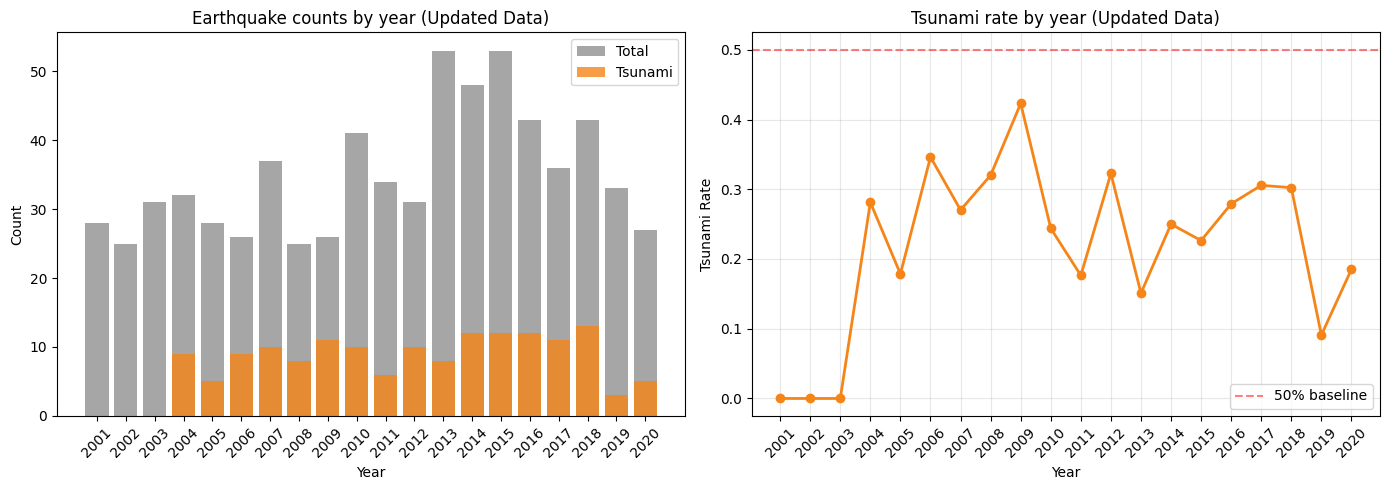


Year-Tsunami correlation: 0.082

Total years in dataset: 20

Tsunami rate by year:
    Year  tsunami_rate  total_count
0   2001         0.000           28
1   2002         0.000           25
2   2003         0.000           31
3   2004         0.281           32
4   2005         0.179           28
5   2006         0.346           26
6   2007         0.270           37
7   2008         0.320           25
8   2009         0.423           26
9   2010         0.244           41
10  2011         0.176           34
11  2012         0.323           31
12  2013         0.151           53
13  2014         0.250           48
14  2015         0.226           53
15  2016         0.279           43
16  2017         0.306           36
17  2018         0.302           43
18  2019         0.091           33
19  2020         0.185           27


In [21]:
year_stats = data_df.groupby('Year').agg({
    'tsunami': ['sum', 'count', 'mean']
}).reset_index()
year_stats.columns = ['Year', 'tsunami_count', 'total_count', 'tsunami_rate']

# Ensure Year is integer
year_stats['Year'] = year_stats['Year'].astype(int)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart with explicit x-axis settings
ax[0].bar(year_stats['Year'], year_stats['total_count'], alpha=0.7, color='gray', label='Total')
ax[0].bar(year_stats['Year'], year_stats['tsunami_count'], alpha=0.8, color='#f58518', label='Tsunami')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Earthquake counts by year (Updated Data)')
ax[0].legend()
# Set x-axis to show all years as integers
ax[0].set_xticks(year_stats['Year'])
ax[0].set_xticklabels(year_stats['Year'], rotation=45)

# Line plot with explicit x-axis settings
ax[1].plot(year_stats['Year'], year_stats['tsunami_rate'], marker='o', color='#f58518', linewidth=2, markersize=6)
ax[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% baseline')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Tsunami Rate')
ax[1].set_title('Tsunami rate by year (Updated Data)')
# Set x-axis to show all years as integers
ax[1].set_xticks(year_stats['Year'])
ax[1].set_xticklabels(year_stats['Year'], rotation=45)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# Print correlation
corr_year = data_df['Year'].corr(data_df['tsunami'])
print(f"\nYear-Tsunami correlation: {corr_year:.3f}")
print(f"\nTotal years in dataset: {len(year_stats)}")
print("\nTsunami rate by year:")
print(year_stats[['Year', 'tsunami_rate', 'total_count']].round(3))

Data seems to be fixed. Lets continue with visualising earthquake epicenters on a map to see if there is regional tsunami patterns.

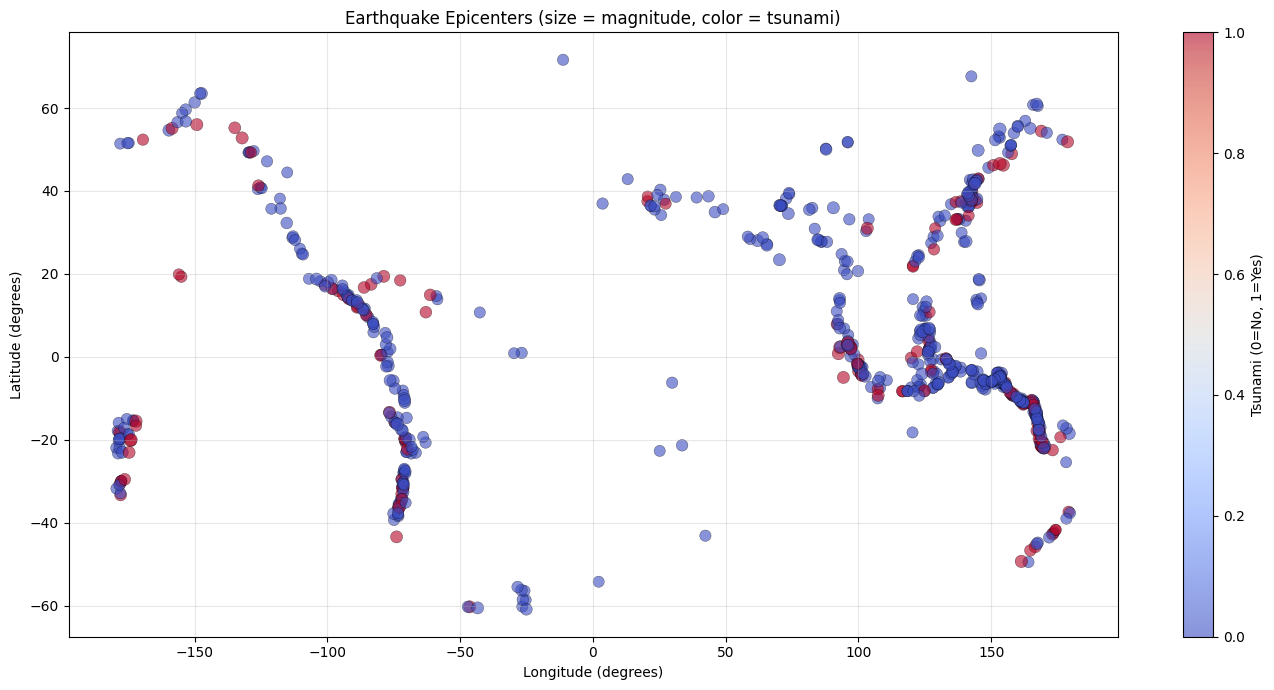

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
scatter = ax.scatter(data_df['longitude'], data_df['latitude'], 
                     c=data_df['tsunami'], cmap='coolwarm', 
                     s=data_df['magnitude']*10, alpha=0.6, edgecolors='black', linewidth=0.3)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Earthquake Epicenters (size = magnitude, color = tsunami)')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Tsunami (0=No, 1=Yes)')
plt.tight_layout()
plt.show()

In [23]:
fig = px.scatter_geo(
    data_df,
    lat='latitude',
    lon='longitude',
    color='tsunami',
    size='magnitude',
    hover_data=['magnitude', 'depth', 'Year', 'tsunami'],
    color_discrete_map={0: '#4c78a8', 1: '#f58518'},
    labels={'tsunami': 'Tsunami'},
    projection='natural earth',
    size_max=15
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor='rgb(243, 243, 243)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 245, 255)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)'
    ),
    height=600,
    width=1200
)

fig.show()

Tsunami risk is highest in oceanic subduction zones but even there not all earthquakes generate tsunamis

We have talked about how surprising it is to magnitude is not correlated to tsunamis. Now we will investigate that. This weak correlation maybe suggest either:
* Magnitude doesnt really matter
* Nonlinear relationship
* Magnitude needs to interact with other features

But first we will see if it is about the wrong (old) data 

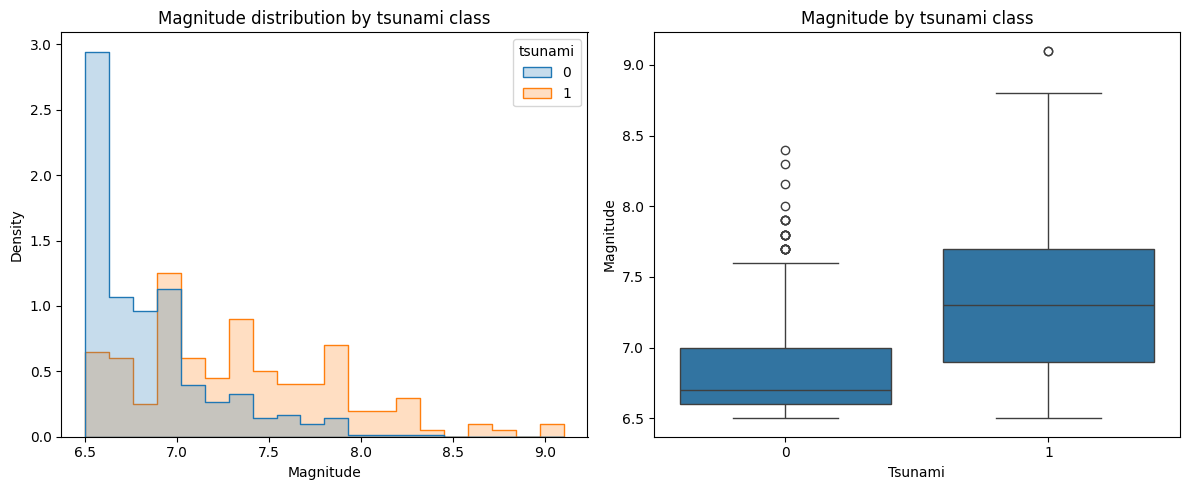

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=data_df, x='magnitude', hue='tsunami', element='step', stat='density', 
             common_norm=False, bins=20, ax=ax[0])
ax[0].set_title('Magnitude distribution by tsunami class')
ax[0].set_xlabel('Magnitude')
ax[0].set_ylabel('Density')

sns.boxplot(data=data_df, x='tsunami', y='magnitude', ax=ax[1])
ax[1].set_title('Magnitude by tsunami class')
ax[1].set_xlabel('Tsunami')
ax[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [25]:
data_df.groupby('tsunami')['magnitude'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
tsunami,,,,,,,,
0,546.0,6.832,0.346,6.5,6.6,6.7,7.0,8.4
1,154.0,7.330,0.550,6.5,6.9,7.3,7.7,9.1


Answer is yes. Magnitude shows a stronger relationship with tsunami occurrence in the updated dataset. The median difference (~0.4) and the higher tail suggest magnitude is a meaningful predictor, though not sufficient alone.

Investigate if the combination of magnitude and depth reveals tsunami patterns (shallow + high magnitude = higher tsunami risk).

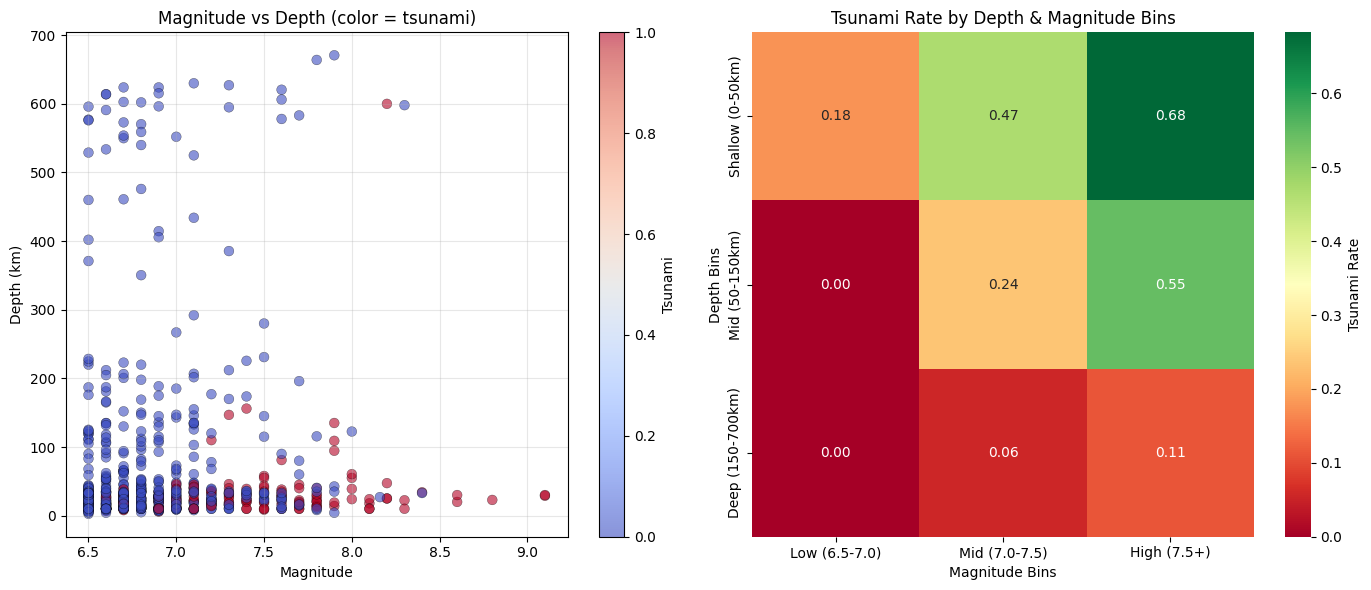

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

scatter = ax[0].scatter(data_df['magnitude'], data_df['depth'], 
                        c=data_df['tsunami'], cmap='coolwarm', 
                        s=50, alpha=0.6, edgecolors='black', linewidth=0.3)
ax[0].set_xlabel('Magnitude')
ax[0].set_ylabel('Depth (km)')
ax[0].set_title('Magnitude vs Depth (color = tsunami)')
ax[0].grid(alpha=0.3)
cbar0 = plt.colorbar(scatter, ax=ax[0])
cbar0.set_label('Tsunami')

data_df['depth_bin'] = pd.cut(data_df['depth'], bins=[0, 50, 150, 700], labels=['Shallow (0-50km)', 'Mid (50-150km)', 'Deep (150-700km)'])
data_df['mag_bin'] = pd.cut(data_df['magnitude'], bins=[6.5, 7.0, 7.5, 10], labels=['Low (6.5-7.0)', 'Mid (7.0-7.5)', 'High (7.5+)'])

pivot_table = data_df.pivot_table(values='tsunami', 
                                   index='depth_bin', 
                                   columns='mag_bin', 
                                   aggfunc='mean', 
                                   observed=True)
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[1], cbar_kws={'label': 'Tsunami Rate'})
ax[1].set_title('Tsunami Rate by Depth & Magnitude Bins')
ax[1].set_xlabel('Magnitude Bins')
ax[1].set_ylabel('Depth Bins')

plt.tight_layout()
plt.show()

The interaction is crucial. Shallow, high-magnitude earthquakes pose the highest tsunami risk. Depth moderates the effect of magnitude. This supports creating a magnitude×depth interaction feature for modeling.

In [27]:
rate_table = data_df.pivot_table(values='tsunami', 
                                 index='depth_bin', 
                                 columns='mag_bin', 
                                 aggfunc=['mean', 'count'], 
                                 observed=True)
rate_table

mean                                   count  \
mag_bin          Low (6.5-7.0) Mid (7.0-7.5) High (7.5+) Low (6.5-7.0)   
depth_bin                                                                
Shallow (0-50km)      0.176895      0.468085    0.682540           277   
Mid (50-150km)        0.000000      0.235294    0.545455            53   
Deep (150-700km)      0.000000      0.055556    0.111111            39   

                                            
mag_bin          Mid (7.0-7.5) High (7.5+)  
depth_bin                                   
Shallow (0-50km)            94          63  
Mid (50-150km)              17          11  
Deep (150-700km)            18           9

In [28]:
data_df.groupby('depth_bin', observed=True)['tsunami'].agg(['mean', 'count']).round(3)

,mean,count
depth_bin,,
Shallow (0-50km),0.268,529
Mid (50-150km),0.108,93
Deep (150-700km),0.026,78


In [29]:
data_df.groupby('mag_bin', observed=True)['tsunami'].agg(['mean', 'count']).round(3)

,mean,count
mag_bin,,
Low (6.5-7.0),0.133,369
Mid (7.0-7.5),0.380,129
High (7.5+),0.602,83


The interaction is crucial. Shallow, high-magnitude earthquakes pose the highest tsunami risk. Depth moderates the effect of magnitude. This supports creating a magnitude×depth interaction feature for modeling.

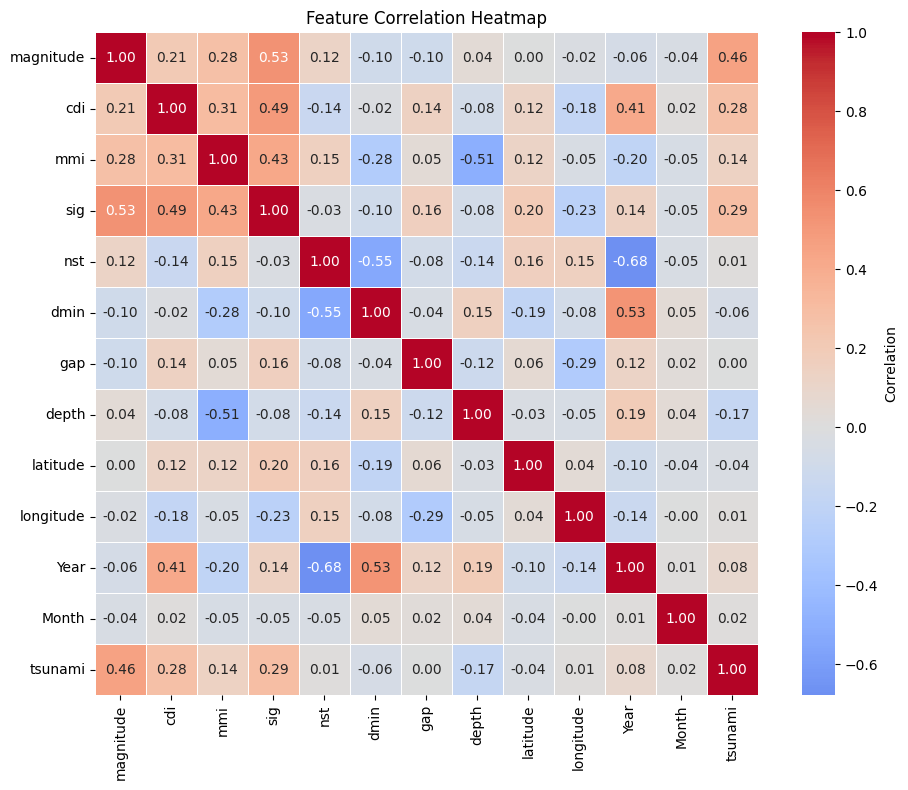


Correlations with tsunami (sorted by absolute value):
magnitude    0.459
sig          0.289
cdi          0.278
depth        0.167
mmi          0.140
Year         0.082
dmin         0.062
latitude     0.035
Month        0.016
nst          0.012
longitude    0.012
gap          0.001
Name: tsunami, dtype: float64


In [30]:
# Compute correlation matrix
corr = data_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print correlations with tsunami sorted
print("\nCorrelations with tsunami (sorted by absolute value):")
print(corr['tsunami'].drop('tsunami').abs().sort_values(ascending=False).round(3))

* Magnitude is now a strong predictor 
* Year correlation is much better (-0.08 vs old +0.65)
* Depth shows expected negative correlation (-0.17) — shallow events are more tsunamigenic.
* nst, dmin, and Year are highly correlated, suggesting temporal/coverage bias. We will excluding one or using dimensionality reduction.

Magnitude is the strongest linear predictor. The Year correlation is much reduced. Depth matters, especially via its interaction with magnitude.

Understand the counterintuitive correlations between station coverage and Year.

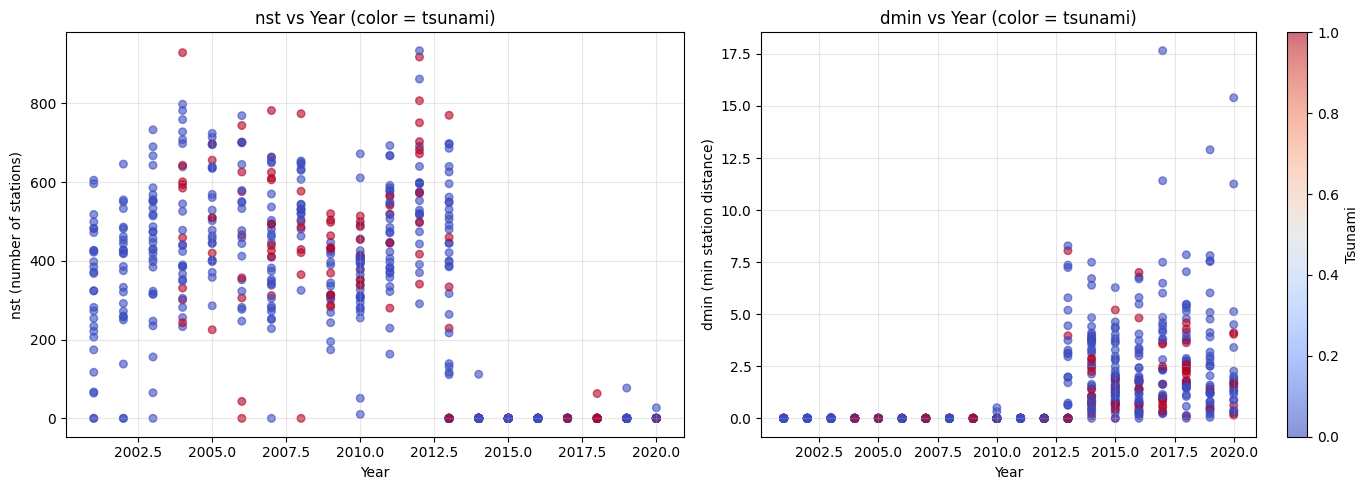


nst statistics by year groups:
            count    mean     std  min    25%    50%    75%    max
year_group                                                        
2001-2010   299.0  428.43  167.11  0.0  323.0  426.0  531.5  929.0
2011-2015   219.0  220.09  270.11  0.0    0.0    0.0  477.0  934.0
2016-2022   182.0    0.92    7.61  0.0    0.0    0.0    0.0   77.0

dmin statistics by year groups:
            count  mean   std  min  25%   50%   75%    max
year_group                                                
2001-2010   299.0  0.00  0.04  0.0  0.0  0.00  0.00   0.51
2011-2015   219.0  1.31  1.84  0.0  0.0  0.46  2.04   8.28
2016-2022   182.0  2.70  2.67  0.0  1.0  1.81  3.76  17.65


In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# nst vs Year
ax[0].scatter(data_df['Year'], data_df['nst'], c=data_df['tsunami'], 
              cmap='coolwarm', alpha=0.6, s=30)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('nst (number of stations)')
ax[0].set_title('nst vs Year (color = tsunami)')
ax[0].grid(alpha=0.3)

# dmin vs Year
scatter = ax[1].scatter(data_df['Year'], data_df['dmin'], c=data_df['tsunami'], 
                        cmap='coolwarm', alpha=0.6, s=30)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('dmin (min station distance)')
ax[1].set_title('dmin vs Year (color = tsunami)')
ax[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=ax[1], label='Tsunami')

plt.tight_layout()
plt.show()

# Print statistics by year groups
print("\nnst statistics by year groups:")
data_df['year_group'] = pd.cut(data_df['Year'], bins=[2000, 2010, 2015, 2023], 
                                labels=['2001-2010', '2011-2015', '2016-2022'])
print(data_df.groupby('year_group', observed=False)['nst'].describe().round(2))

print("\ndmin statistics by year groups:")
print(data_df.groupby('year_group', observed=False)['dmin'].describe().round(2))

* Very weak correlations with tsunami: both near 0 (from correlation heatmap)
* Temporal artifact embedded. The nst and dmin values are confounded with time period

So we will drop the nst and dmin columns.

To understand the depth-tsunami relationship we will visualize depth distribution across tsunami classes 

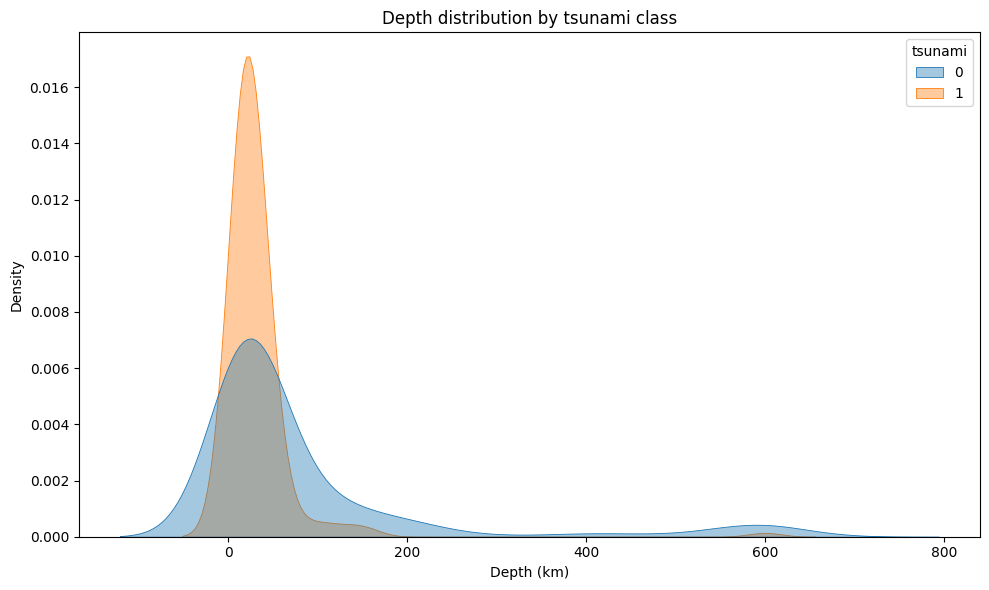


Depth statistics by class:
         count    mean      std   min     25%    50%    75%     max
tsunami                                                            
0        546.0  84.942  145.310  2.70  14.208  28.95  68.00  670.81
1        154.0  31.570   51.779  5.81  14.260  22.42  32.75  600.00


In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.kdeplot(data=data_df, x='depth', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6)
ax.set_title('Depth distribution by tsunami class')
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Density')
plt.tight_layout()
plt.show()

# Print statistics
print("\nDepth statistics by class:")
print(data_df.groupby('tsunami')['depth'].describe().round(3))

Shallow depth is a strong indicator for tsunami potential, but the overlap means depth works best in combination with other features (especially magnitude, as we saw in the interaction analysis).

Lets examine distributions of sig, cdi, and mmi to understand their relationships with tsunami occurrence.

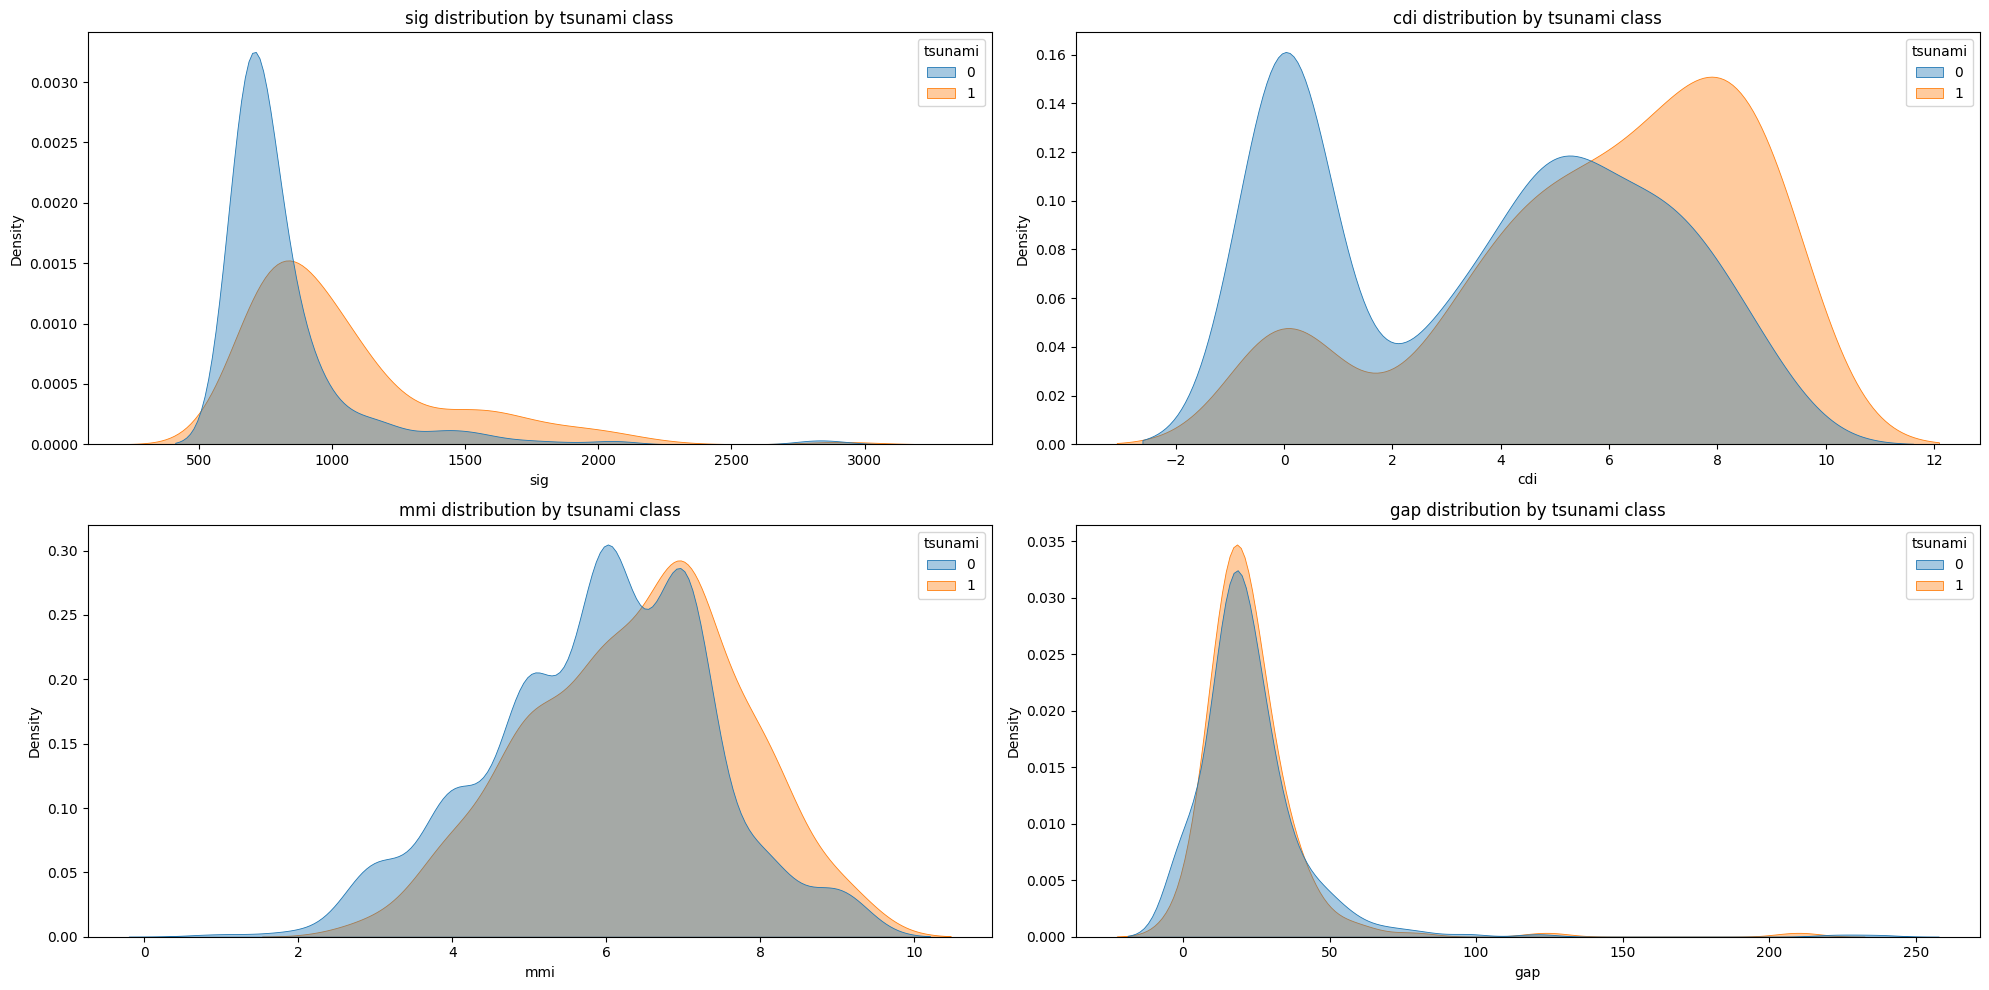


sig statistics by class:
         count     mean     std    min    25%    50%      75%     max
tsunami                                                              
0        546.0   818.72  280.32  650.0  675.0  732.0   831.75  2910.0
1        154.0  1040.38  377.31  650.0  782.0  917.0  1144.00  2910.0

cdi statistics by class:
         count  mean   std  min  25%  50%  75%  max
tsunami                                            
0        546.0  3.68  3.07  0.0  0.0  4.0  6.0  9.0
1        154.0  5.79  2.82  0.0  4.0  6.0  8.0  9.0

mmi statistics by class:
         count  mean   std  min  25%  50%  75%  max
tsunami                                            
0        546.0  5.91  1.41  1.0  5.0  6.0  7.0  9.0
1        154.0  6.39  1.34  3.0  5.0  7.0  7.0  9.0

gap statistics by class:
         count   mean    std  min    25%   50%    75%    max
tsunami                                                     
0        546.0  23.33  22.23  0.0  14.00  19.0  27.88  239.0
1        154.0  2

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# sig distribution
sns.kdeplot(data=data_df, x='sig', hue='tsunami', common_norm=False, fill=True, 
            alpha=0.4, linewidth=0.6, ax=axes[0, 0])
axes[0, 0].set_title('sig distribution by tsunami class')
axes[0, 0].set_xlabel('sig')

# cdi distribution
sns.kdeplot(data=data_df, x='cdi', hue='tsunami', common_norm=False, fill=True, 
            alpha=0.4, linewidth=0.6, ax=axes[0, 1])
axes[0, 1].set_title('cdi distribution by tsunami class')
axes[0, 1].set_xlabel('cdi')

# mmi distribution
sns.kdeplot(data=data_df, x='mmi', hue='tsunami', common_norm=False, fill=True, 
            alpha=0.4, linewidth=0.6, ax=axes[1, 0])
axes[1, 0].set_title('mmi distribution by tsunami class')
axes[1, 0].set_xlabel('mmi')

# gap distribution
sns.kdeplot(data=data_df, x='gap', hue='tsunami', common_norm=False, fill=True, 
            alpha=0.4, linewidth=0.6, ax=axes[1, 1])
axes[1, 1].set_title('gap distribution by tsunami class')
axes[1, 1].set_xlabel('gap')


plt.tight_layout()
plt.show()

# Print statistics
print("\nsig statistics by class:")
print(data_df.groupby('tsunami')['sig'].describe().round(2))

print("\ncdi statistics by class:")
print(data_df.groupby('tsunami')['cdi'].describe().round(2))

print("\nmmi statistics by class:")
print(data_df.groupby('tsunami')['mmi'].describe().round(2))

print("\ngap statistics by class:")
print(data_df.groupby('tsunami')['gap'].describe().round(2))

* cdi - Best separation (distinct bimodal patterns)
* sig - Moderate separation (shifted distributions)
* mmi - Weak separation (high overlap)
* gap - Weak separation (high overlap)

In [53]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, len(series), outliers / len(series) * 100

numeric_cols = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
outlier_summary = []

for col in numeric_cols:
    n_outliers, n_total, pct = count_outliers(data_df[col])
    outlier_summary.append({
        'Feature': col,
        'Outliers': n_outliers,
        'Total': n_total,
        'Percent': round(pct, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Percent', ascending=False)
outlier_df

,Feature,Outliers,Total,Percent
7,depth,123,700,17.57
3,sig,67,700,9.57
5,dmin,61,700,8.71
6,gap,44,700,6.29
0,magnitude,33,700,4.71
2,mmi,1,700,0.14
1,cdi,0,700,0.00
4,nst,0,700,0.00
8,latitude,0,700,0.00
9,longitude,0,700,0.00


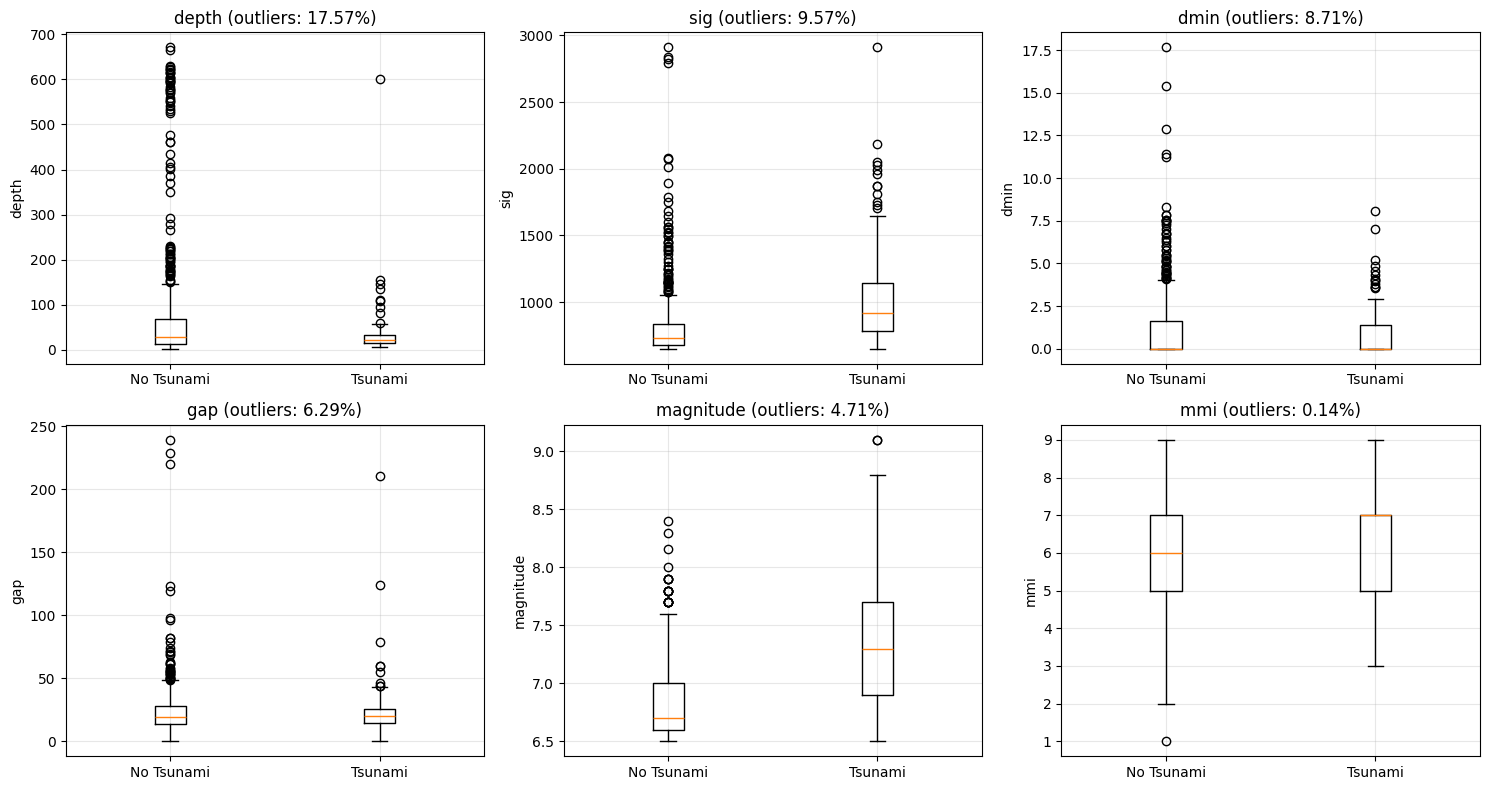

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
top_outlier_features = outlier_df.head(6)['Feature'].tolist()

for idx, col in enumerate(top_outlier_features):
    axes[idx].boxplot([data_df[data_df['tsunami']==0][col], 
                       data_df[data_df['tsunami']==1][col]], 
                      tick_labels=['No Tsunami', 'Tsunami'])
    axes[idx].set_title(f'{col} (outliers: {outlier_df[outlier_df["Feature"]==col]["Percent"].values[0]}%)')
    axes[idx].set_ylabel(col)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

All outliers represent real phenomena (deep earthquakes, high-magnitude events, remote locations, poor coverage). So we wont remove outliers. Instead we'll use:
* Tree-based models (naturally handle outliers)
* Robust scaling for linear models
* Consider log transforms for highly skewed features if needed